# About

In this notebook I explore fundamental concepts of [recommender systems](https://en.wikipedia.org/wiki/Recommender_system). 

## Concepts covered
* Recommender systems
* Collaborative filtering
    * user-based
    * item-based
* Content-based filtering
* NLP
* TF-IDF
    
* Similarity metrics (centered cosine/Pearson correlation coefficient)
* Matrix factorization techniques 

## Tools used
* scikit-learn

## References
To get started with recommender systems, I've used these resources and the links therein:
* https://machinelearningmastery.com/recommender-systems-resources/
* https://www.datacamp.com/community/tutorials/recommender-systems-python
* https://realpython.com/build-recommendation-engine-collaborative-filtering/ 


# Imports, setup

In [294]:
import numpy as np
from random import choice

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

In [70]:
from sklearn.metrics.pairwise import linear_kernel

In [9]:
sns.set_style("whitegrid")

# The data
I'll use Kaggle [The Movies dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset/data), a subset of the [MovieLens dataset](https://grouplens.org/datasets/movielens). It consists of a number of csv-files:

In [29]:
ls data

credits.csv   links.csv        movies_metadata.csv  ratings_small.csv
keywords.csv  links_small.csv  ratings.csv


The main data files I'll use are *metatadata.csv* and *ratings.csv*.

* *metadata.csv*: contains information about the movie items (rows) in the form of 24 features (columns)  There are 45,466 movies listed. 
* *ratings.csv*: contains individual user ratings of movies. Columns are `userId`, `movieId`, `rating`, `timestamp`. The `movieid` is linked to the IMDB and TMDb id's via *link.csv*.

In [10]:
metadata = pd.read_csv('data/movies_metadata.csv', low_memory=False)
ratings = pd.read_csv('data/ratings.csv')
links = pd.read_csv('data/links.csv')

In [158]:
display(metadata.head(3))
print()
print("Number of records = {}, number of features = {}.".format(*metadata.shape))
print("Columns:", ', '.join(metadata.columns))

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0



Number of records = 45466, number of features = 24.
Columns: adult, belongs_to_collection, budget, genres, homepage, id, imdb_id, original_language, original_title, overview, popularity, poster_path, production_companies, production_countries, release_date, revenue, runtime, spoken_languages, status, tagline, title, video, vote_average, vote_count


In [154]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523


In [152]:
links.head(3)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0


# Preprocessing

## Overview missing values
The overview has 2% NaN values. I impute these with an empty string.

In [18]:
len(metadata[metadata['overview'].isna()])/len(metadata)

0.020982712356486164

In [19]:
metadata['overview'] = metadata['overview'].fillna('')

# A very basic recommender
A recommender takes as input a user and outputs one or more recommended items, or takes a user and an item and outputs a predicted rating (which can then be used to recommend that item or not). A very simple recommender function would be to always output the top-$n$ most popular items. This not completely trivial, since "popular" concerns both how much people liked an item and how many people liked the item. This is clear from looking at the top 10:

In [163]:
metadata.sort_values(by='vote_average', ascending=False)[['title', 'vote_average', 'vote_count']].head(10)

,title,vote_average,vote_count
21642,Ice Age Columbus: Who Were the First Americans?,10.0,1.0
15710,If God Is Willing and da Creek Don't Rise,10.0,1.0
22396,Meat the Truth,10.0,1.0
22395,Marvin Hamlisch: What He Did For Love,10.0,1.0
35343,Elaine Stritch: At Liberty,10.0,1.0
186,Reckless,10.0,1.0
45047,The Human Surge,10.0,1.0
22377,The Guide,10.0,1.0
22346,هیچ کجا هیچ کس,10.0,1.0
1634,Other Voices Other Rooms,10.0,1.0


These are all very unpopular in terms of user activity. We see from the cumulative distribution function that more than 80% of movies have less than 100 votes.

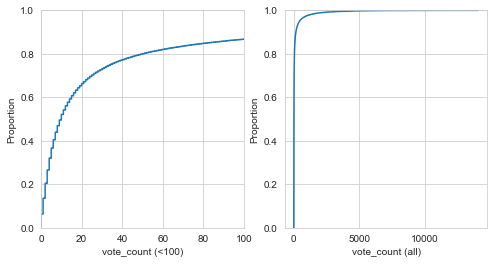

In [226]:
fig, axes = plt.subplots(1,2, figsize=(4*2,4))

ax = axes[0]
sns.ecdfplot(metadata, x="vote_count", ax=ax)
ax.set_xlabel('vote_count (<100)')

ax.set_xlim(0, 100)
ax = axes[1]
sns.ecdfplot(metadata, x="vote_count", ax=ax)
ax.set_xlabel('vote_count (all)');

We'd like to give greater weight to movies with more votes. One way would be to calculate a weighted score function $s_i = \bar{r}_i n_i$
where $r_i$ and $n_i$ are `vote_average` and `vote_count` of movie $i$, respectively. Then, for instance doubling the number of votes would count for as much as doubling the average rating (this is the same as the summing all the ratings $s_i = \sum_{j} r_{ij}$.). 

In [236]:
metadata['vote_total'] = metadata.apply(lambda row: row.vote_average*row.vote_count, axis=1)

In [238]:
metadata.sort_values(by='vote_total', ascending=False)[['title', 'vote_average', 'vote_count',  'vote_total']].head(10)

,title,vote_average,vote_count,vote_total
15480,Inception,8.1,14075.0,114007.5
12481,The Dark Knight,8.3,12269.0,101832.7
22879,Interstellar,8.1,11187.0,90614.7
17818,The Avengers,7.4,12000.0,88800.0
14551,Avatar,7.2,12114.0,87220.8
26564,Deadpool,7.4,11444.0,84685.6
2843,Fight Club,8.3,9678.0,80327.4
20051,Django Unchained,7.8,10297.0,80316.6
23753,Guardians of the Galaxy,7.9,10014.0,79110.6
292,Pulp Fiction,8.3,8670.0,71961.0


This looks much better already. However, since we are are looking for high-quality movies that an individual user will (rather than trying to quantify how much total "like" a movie has generated) this may be somewhat too aggressive. For instance, some movies with relatively low average score make the top-10, such as *Avatar*, perhaps not because it was a very good movie, but because it was innovative or trendy at the time to see go see it. 

IMDB uses a weighted average which is only calculated for movies with number of votes above a certain cutoff $n_c$, $n_i > n_c$:

\begin{equation}
s_i' = 
\frac{n_i \bar{r}_i  + n_c \bar{r}_\text{tot}}{n_i + n_{c}},
\end{equation}

where $\bar{r}_{\text{tot}}$ is the average rating of all movies. For $n_i \gg n_c$, the number of votes  will not be relevant any longer, only the average rate, $s'_i \approx \bar{r_i}$.

In [239]:
r_tot = metadata.vote_average.mean()
print(r_tot)

5.618207215134185


The cutoff hyperparameter $n_c$ we can set to the 90% quantile, so that 90% of all data will be above the cutoff and so be given a score:

In [241]:
n_c = metadata.vote_count.quantile(0.9)
print(n_c)

160.0


In [248]:
def weighted_score(row):
    r_i = row.vote_average
    n_i = row.vote_count
    if n_i < n_c: 
        return 0
    else:
        return (n_i*r_i + n_c*r_tot)/(n_i+ n_c)

In [249]:
metadata['weighted'] = metadata.apply(weighted_score, axis=1)

In [250]:
metadata.sort_values(by='vote_weighted', ascending=False)[['title', 'vote_average', 'vote_count',  'vote_total', 'vote_weighted']].head(10)

,title,vote_average,vote_count,vote_total,vote_weighted
314,The Shawshank Redemption,8.5,8358.0,71043.0,8.445869
834,The Godfather,8.5,6024.0,51204.0,8.425439
10309,Dilwale Dulhania Le Jayenge,9.1,661.0,6015.1,8.421453
12481,The Dark Knight,8.3,12269.0,101832.7,8.265477
2843,Fight Club,8.3,9678.0,80327.4,8.256385
292,Pulp Fiction,8.3,8670.0,71961.0,8.251406
522,Schindler's List,8.3,4436.0,36818.8,8.206639
23673,Whiplash,8.3,4376.0,36320.8,8.205404
5481,Spirited Away,8.3,3968.0,32934.4,8.196055
2211,Life Is Beautiful,8.3,3643.0,30236.9,8.187171


This top-list now looks very different. All movies have high average score and the Bollywood movie *Dilwale Dulhania Le Jayenge* comes in at number 3, even though it has a much lower number of votes than the other (mostly Hollywood) movies.

# Content-based filtering
A more reifned approach would be to actually make use of the features of the movies, to try to find movies similar to one another. Given an item that a user liked recently, one can then spawn recommendations for similar items for that specific user. This is an example of *content-based filtering*. Here, one of the most informative feature is the movie overview text string. For instance,

In [275]:
for v in metadata.iloc[0][['title', 'overview']]:
    print(v)

Toy Story
Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.


We can think of all movie items living in some space, closer or further away from each other depending on how similar they are. To recommend *similar* items to any given item, 
* the items needs to  be vectorized (given features) and embedded into a common space, and 
* a similarity/distance metric in this space neededs to be defined.

In this case we are considering text data, so we use standard NLP (Natural Language processing) techniques from `scikit-learn` for achieving this, see the 
[scikit-learn text feature extraction overview](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction).

## Vectorization

### Tokenize, count
I use a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) vectorization approach, where each word is considered independently of its relation to other words. Each overview ("document") is turned into a vector by tokenizing it, counting the number of tokens in each overview and then representing the overview by its frequency of tokens.

In [21]:
vectorizer = CountVectorizer(stop_words='english')

In [23]:
overview_vectors = vectorizer.fit_transform(metadata['overview'])

In [24]:
overview_vectors

<45466x75827 sparse matrix of type '<class 'numpy.int64'>'
	with 1210882 stored elements in Compressed Sparse Row format>

The matrix, with items/documents/movies as rows (45466) and tokens/words/features as columns (75827), is represented as a sparse Python matrix because most words will not be present in a single document. Here are examples of some of the features.

In [43]:
vectorizer.get_feature_names()[::10_000]

['00',
 'cabrell',
 'ebbs',
 'hindelang',
 'macdowell',
 'period',
 'shapeshifting',
 'unshakable']

In raw form the matrix displays mostly 0s and 1s,

In [59]:
v5 = overview_vectors.toarray()[:5, :]
print(v5)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [60]:
v5[np.where(v5 > 0)]

array([1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

### Normalize, TF-IDF
At this point, there is no added normalization/weighting, the matrix simply contains absolute counts. However, some words carry more information than others in distinguishing movies. For instance, it's not useful to know that two movies containing "the" in the overview text, while the two movies described by the word "love" may very well be similar in some way. The [term frequency–inverse document frequency (TF-IDF)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a standard approach for putting less words on words that occur commonly in all documents, thus reducing  baseline noise. Also, different overviews may be written more or less wordy which we don't necessarily want to take into account by using raw counts. TF-IDF is weight is calculated and applied to each element in the matrix (document and token) and is defined as

\begin{equation}
\text{tfidf(d, t)} = \text{tf}(d, t) \cdot \text{idf}(t) = 
\frac{n^d_t}{\sum_{t'} n^d_{t'}} \cdot
\ln \frac{N}{N_t}
\end{equation}

where $n^d_t$ are the counts of token $t$ in the document $d$, $N$ is the total number of documents and $N_t$ is the number of of documents where the token $t$ appears ($n_t > 0$). The TF term sets the importance of the word relative to the document and the IDF term sets the importance of the word for the whole corpus (set of documents). For each document $d$ we get a vector with elements $u_t = \text{tfidf}(d,t)$.

In `scikit-learn` we can apply the `TfidTransformer` to our count matrix to apply these weights,

In [53]:
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(overview_vectors)
tfidf

<45466x75827 sparse matrix of type '<class 'numpy.float64'>'
	with 1210882 stored elements in Compressed Sparse Row format>

Alternatively, `TfidfVectorizer` does both vectorization and transformation in one go. Now we have non-integer weights in our feature matrix:

In [62]:
t5 = tfidf.toarray()[:5,:]
t5[np.where(t5 > 0)]

array([0.14091177, 0.41178366, 0.1474882 , 0.12380553, 0.10635375,
       0.50280387, 0.12544428, 0.1348315 , 0.13281884, 0.10438761,
       0.13311522, 0.10093917, 0.10142919, 0.10739706, 0.20627925,
       0.08718689, 0.11907123, 0.10339358, 0.09190798, 0.13434817,
       0.11124851, 0.11355919, 0.13008016, 0.14878285, 0.48098271,
       0.19079662, 0.15046466, 0.33017085, 0.15233435, 0.15233435,
       0.11584412, 0.14384663, 0.19018379, 0.11581823, 0.16446724,
       0.14142889, 0.37109888, 0.14635122, 0.13248383, 0.13125797,
       0.18900392, 0.19079662, 0.1051242 , 0.14821605, 0.21120412,
       0.15436507, 0.14038016, 0.15282588, 0.24391034, 0.19142579,
       0.13520372, 0.14030701, 0.16820596, 0.14663604, 0.13716579,
       0.16637261, 0.07978208, 0.08644042, 0.21310699, 0.14326062,
       0.11553371, 0.21536409, 0.17664301, 0.19193114, 0.22371227,
       0.15127508, 0.0857531 , 0.19058968, 0.17405374, 0.17361068,
       0.14865206, 0.16482721, 0.14306754, 0.12357524, 0.14881

`TfidfTransformer` also normalizes the matrix (using L2 norm by default),

In [69]:
np.isclose(np.sum(t5**2, axis=1), 1).all()

True

## Similarity
Now we have a vector space and each document being represented by a vector  , and so can start defining similarities between these data points.

[Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) is defined as the cosine of the angle between two vectors

\begin{equation}
cos\theta(u, v) =  \frac{u \cdot v}{|u||v|} = \frac{\sum_t u_t v_t}{\sqrt{\sum_t u_t^2} \sqrt{\sum_t v_t^2} },
\end{equation}

where $u$ and $v$ are vectors (with elements $u_t$, $v_t$). Cosine similarity is useful for providing a relative measure of similarity rather than absolute.

We are after all pair-wise similarites, so a $45466 \times 45466$ similarity matrix. Since our TF-IDF vectors are normalized to 1, $cos\theta(u,v) = \sum_t u_t \cdot v_t$, and we can use the [scikit-learn linear kernel](https://scikit-learn.org/stable/modules/metrics.html#linear-kernel).

In [71]:
costheta = linear_kernel(tfidf, tfidf)

In [73]:
costheta.shape

(45466, 45466)

## A content-based recommender function
Given any movie, we can now define a recommender function by spawning a top-list of similar items. To get a personalized recommendation, for a specific user, a simple way is to find a movie "seed" and find similar movies based on that. Below, I get take the seed item to be the most highly rated movie of that user thus far. Then, given a user, we can create a content-based filtering recommender funciton as follows:

In [257]:
def recommend_for_user(user_id, num_recommendations=10):
    """Return a set of recommendations for user, based on the user's highest rated movie."""
    # Get most highly rated movieId of user
    movie_id = str(int(ratings[ratings.userId == user_id].sort_values('rating', ascending=False).iloc[0].movieId))
    
    # Link it to the TMDB id
    tmdb_id = str(int(links[links.movieId == movieid].tmdbId))
    
    # Get metadata dataframe index
    seed_index = metadata.index[metadata.id == tmdb_id].to_list()[0]    
    indices = range(len(costheta))
    
    # Get indices of top-n similar items (+1 for the diagonal, the same item)
    top = sorted(zip(indices, costheta[seed_index]), key= lambda t: t[1], reverse=True)[:num_recommendations]
    top_indices, top_values = list(zip(*top))
    
    # Return the indices and similarity of the recommendations (including the highest rated one)
    return list(top_indices), list(top_values)

In [266]:
def sample_user():
    return choice(ratings.userId.unique())

We can now have a look at how this performs for a randomly chosen user:

In [293]:
user = sample_user()
top_indices, top_values = recommend_for_user(user, num_recommendations=5)

for i, v in zip(top_indices, top_values):
    print(metadata.iloc[i].title, v)
    print('"', metadata.iloc[i].overview, '"', sep='')
    print()

Whiplash 0.9999999999999999
"Under the direction of a ruthless instructor, a talented young drummer begins to pursue perfection at any cost, even his humanity."

The Adonis Factor 0.2131529331643415
"Gay men and their pursuit of physical perfection."

Ninja III: The Domination 0.16188279098729355
"A female aerobic instructor is possessed by an evil spirit of a fallen ninja when coming to his aid. The spirit seeks revenge on those who killed him and uses the female instructor's body to carry out his mission. The only way the spirit will leave aerobic instructor's body is with the help of another ninja."

The Sitter 0.15072027462121784
"A prosperous couple find the perfect live-in nanny but soon discover she intends to do her job to deadly perfection."

Kung Fu Jungle 0.14972880886583645
"A martial arts instructor working at a police academy gets imprisoned after killing a man by accident. But when a vicious killer starts targeting martial arts masters, the instructor offers to help the 

Above, *Whiplash* was this user's top-rated movie. Since this movie was the seed of the similarity-based recommendation, it gets a similarity score of 1. The top recommendation is the *Adonis Factor*. Scanning through these summaries, we realize that the main similarity between these items are that they have to do with "perfection" or "instructor".

This recommender could be improved by doing more work on the NLP vectorization and by adding more features, besides those of the the synopsis. Also, this approach doesn't make use of most of the information in the ratings dataset, a user's full history or similarity to other users. That's exactly what *collaborative filtering*, another branch of recommender systems, leverages.

# Collaborative filtering